In [123]:
%matplotlib inline

import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import skewnorm, exponnorm
from scipy.optimize import curve_fit

In [124]:
from eqns import *

## our model

this is the first attempt at this, from the SL20 notebook

In [3]:
# our first attempt at doing this!
def stalldown(BV, age, Ro1=0.4, Ro2=0.6, skw=-2, samp=0.5,
              return_dP=False):
    '''
    BV: the B-V color of star(s)
        --> prob need to switch to Teff
    age: ages of star(s) in Myr (per Angus eqns)
    
    Ro1: Rossby number the gap starts at
    Ro2: Rossby number roughly the gap ends at
    `stalldown` uses Cranmer & Saar (2011) tau to estimate periods (P1, P2) 
        that these Ro's occur at
        
    `stalldown` inverts Angus+(2015) gyrochrone relation to estimate times (t1, t2)
        that these periods occur at

    skw: skewness of the stall vs acceleration
    
    samp: the stall amplitude, calculated as (P1 - P2)*samp
    
    return_dP: if True, return the period the stall dP(BV,age). 
        If Flase (default), return the Angus+(2015) gyro P(BV,age) 
        with dP included.
    '''

    Teff = bv2teff(BV)
    tau = CranmerSaar2011_eqn36(Teff)
    
    P1 = Ro1 * tau
    P2 = Ro2 * tau
    t1 = Angus2015_age(BV,P1)
    t2 = Angus2015_age(BV,P2)

    dP = skewnorm(skw, loc=(t1+t2)/2, scale=(t2 - t1)/2).pdf(age) 
    # the normalization of the skewnorm dist might not be exactly right... but its close
    dP = dP  * (t2 - t1)/2 * np.sqrt(2*np.pi) / 2 * np.exp(1/(2*np.abs(skw))) * ((P1-P2)*samp)

    if return_dP:
        return dP
    else: 
        return Angus2015(BV, age) + dP

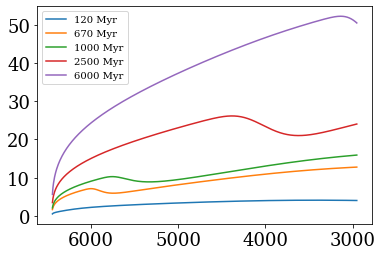

In [4]:
Ro1, Ro2, skw, samp = 0.5, .9, -3, 0.5

# lets make some fake clusters, see how it looks
bv_c = np.linspace(0.451, 1.9, 1000)
age_c = [120, 670, 1000, 2500, 6000]

for k in range(len(age_c)):
    plt.plot(bv2teff(bv_c), stalldown(bv_c, age_c[k], 
                                Ro1=Ro1, Ro2=Ro2, skw=skw, samp=samp), 
                label=str(age_c[k])+' Myr')
plt.legend(fontsize=10)
plt.gca().invert_xaxis()


In [243]:
# a VERY handy ensemble table from Curtis+2020

cl = Table.read('apjabbf58t5_mrt.txt', format='ascii.fixed_width_no_header', 
                names=['Cluster', 'Age', 'Avmag', 'DR2Name', 'Oname', 'RAdeg', 'DEdec', 
                       'BPRP', 'BPRP0', 'Gmag', 'MGmag', 'Teff', 'Prot'], 
                col_ends=(12, 18, 24, 53, 68, 79, 90, 99, 108, 117, 126, 134, 144),
               data_start=35).to_pandas()

In [232]:
print(cl['Age'].unique())
print(cl['Cluster'].unique())

[0.12 0.67 1.   1.4  2.5  2.7 ]
['Pleiades' 'Praesepe' 'NGC 6811' 'NGC 752' 'NGC 6819' 'Ruprecht 147']


## fit the clusters

In [191]:
def myfunc(x, Ro1, Ro2, skw, samp):
    bv, age = x
    dP = stalldown(bv, age, Ro1=Ro1, Ro2=Ro2, skw=skw, samp=samp, return_dP=True)
    P = dP + Angus2015(bv, age)
    return P

Text(0.5, 1.0, 'Ro1=0.6475 Ro2=1.0060 skw=-1.000 samp=0.4731')

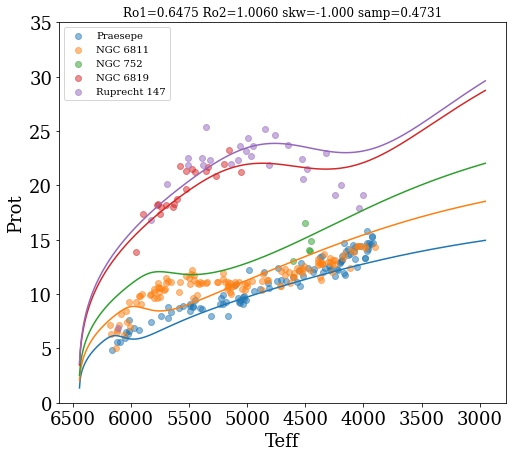

In [294]:
# try fitting them all together!
# except Pleiades, b/c the gyrochrone doesn't work there

Ro1, Ro2, skw, samp = 0.4, .9, -2, 0.1

ok = np.where((cl['Age'] > .5) & 
              (cl['Teff'] > 3900) & 
              (cl['Teff'] < 6200))[0]

p0 = (Ro1, Ro2, skw, samp)
X = (teff2bv(cl['Teff'][ok].values), cl['Age'][ok].values*1e3)

popt, pcov = curve_fit(myfunc, X, cl['Prot'].values[ok], p0=p0, maxfev=10000, 
                       bounds=([0.1, 0.3, -50, 0.01],
                               [0.9, 1.8, -1, 1]))

# then plot them individually

plt.figure(figsize=(8,7))
for k in cl['Cluster'][ok].unique():
    ok2 = cl['Cluster'][ok] == k
    plt.scatter(cl['Teff'][ok][ok2], cl['Prot'][ok][ok2], alpha=0.5, label=k)
plt.gca().invert_xaxis()
plt.xlabel('Teff')
plt.ylabel('Prot')
plt.legend(fontsize=10)

for k in range(len(cl['Age'][ok].unique())):
    plt.plot(bv2teff(bv_c), stalldown(bv_c, cl['Age'][ok].unique()[k]*1e3, 
                                Ro1=popt[0], Ro2=popt[1], skw=popt[2], samp=popt[3]) )
plt.ylim(0,35)
plt.title('Ro1='+format(popt[0],'6.4f') + ' Ro2='+format(popt[1],'6.4f')+
          ' skw='+format(popt[2],'6.3f')+' samp='+format(popt[3],'6.4f'),fontsize=12)

So fitting all of the clusters together (ignoring the Pleiades) doesn't quite work. The Gyrochrone isn't quite tuned to hit these ages with the stall feature...

# per-cluster approach
One instructive approach is to fit each cluster (or clusters of similar ages), and see what kind of stall feature we get

[ 0.4757839   0.62950438 -1.74754025  0.43905146]
[ 0.48037859  0.77893968 -1.98533413  0.457417  ]
[ 0.6780392   1.02697328 -1.73565721  0.77865171]


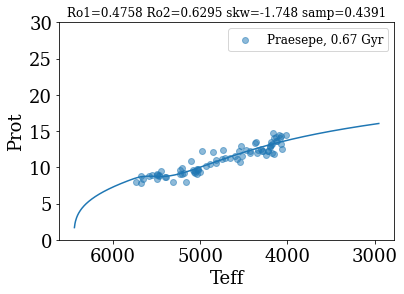

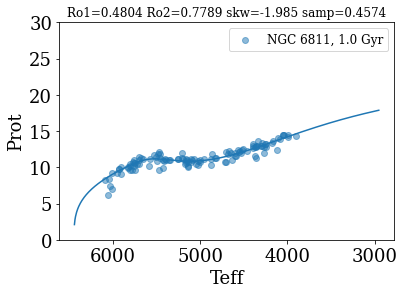

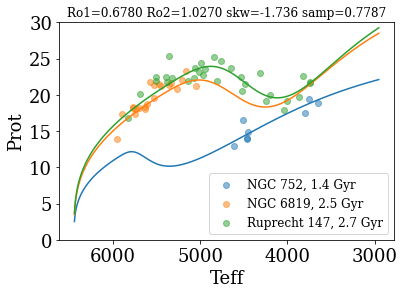

In [261]:
# try fitting clusters of similar ages together... 

Ro1, Ro2, skw, samp = 0.4, .9, -4, 0.1

p0 = (Ro1, Ro2, skw, samp)
bnds = ([0.1, 0.3, -50, 0.01],
        [0.9, 1.8, -1, 1])

# define the age bins, and some variable
# temp bins based on by-hand tuning of gyrochrone
abins = [.5, .9, 1.25, 3.]
tbins = [[4000,3900, 3300], [5800,6100,6100]]

for k in range(len(abins)-1):
    ok = np.where((cl['Age'] >= abins[k]) & 
                  (cl['Age']<= abins[k+1]) & 
                  (cl['Teff'] >= tbins[0][k]) & 
                  (cl['Teff'] <= tbins[1][k]))[0]

    X = (teff2bv(cl['Teff'][ok].values), cl['Age'][ok].values*1e3)

    # fit all clusters within each bin
    popt, pcov = curve_fit(myfunc, X, cl['Prot'].values[ok], p0=p0, maxfev=10000, 
                           bounds=bnds)
    print(popt)
    # plot clusters individually
    plt.figure()
    for j in cl['Cluster'][ok].unique():
        ok2 = cl['Cluster'][ok] == j
        plt.scatter(cl['Teff'][ok][ok2], cl['Prot'][ok][ok2], alpha=0.5, 
                    label=str(j)+', '+str(cl['Age'][ok].values[ok2][0])+' Gyr')
    plt.legend(fontsize=12)

    for j in range(len(cl['Age'][ok].unique())):
        plt.plot(bv2teff(bv_c), stalldown(bv_c, cl['Age'][ok].unique()[j]*1e3, 
                                Ro1=popt[0], Ro2=popt[1], skw=popt[2], samp=popt[3]) )

    plt.gca().invert_xaxis()
    plt.xlabel('Teff')
    plt.ylabel('Prot')

    plt.ylim(0,30)
    plt.title('Ro1='+format(popt[0],'6.4f') + ' Ro2='+format(popt[1],'6.4f')+
              ' skw='+format(popt[2],'6.3f')+' samp='+format(popt[3],'6.4f'),fontsize=12)

This works quite well, making some considerations manually for where the gyrochrones seem to track well (i.e. were probably tuned based on older samples, etc)

Some basic trends pop out here, which are along the lines of what we expect: 
- for the 2 younger cluster bins here, the stall parameters are VERY close, could probably do them together
    - *almost*, but I tried and it doens't quite work
- the `stalldown` model works well for all age bins I've tried with these clusters generally

## another approach
Instead of assuming the gyrochrone and fitting the stalldown parameters, we could flip the script a bit. Assume the stalldown coefficients from one of the model runs are perfect (e.g. NGC 6811), and then re-fit for the actual gyrochrone coefficients (it's only 4 numbers, right?)

In [286]:
# the initial guesses, from Ruth's published paper!
p0 = (0.55, 0.4, -0.45, 0.31)

def myfunc2(x, c1,c2,c3,c4):
    ''' this code essentially is a new gyrochrone... '''
    BV, age = x
    
    # hardcode stalldown params:
    Ro1, Ro2, skw, samp = 0.48037859,  0.77893968, -1.98533413,  0.457417
#     Ro1, Ro2, skw, samp = 0.5,  0.8, -2,  0.5
    
    # recreate the stalldown code above...
    Teff = bv2teff(BV)
    tau = CranmerSaar2011_eqn36(Teff)
    
    P1 = Ro1 * tau
    P2 = Ro2 * tau

    # but instead make the gyro params variable to fit the data
#     t1 = Angus2015_age(BV,P1)
#     t2 = Angus2015_age(BV,P2)
    t1 = np.power(P1 / (c2 * ((BV + c3) ** c4)), 1. / c1)
    t2 = np.power(P2 / (c2 * ((BV + c3) ** c4)), 1. / c1)

    dP = skewnorm(skw, loc=(t1+t2)/2, scale=(t2 - t1)/2).pdf(age) 
    # the normalization of the skewnorm dist might not be exactly right... but its close
    dP = dP  * (t2 - t1)/2 * np.sqrt(2*np.pi) / 2 * np.exp(1/(2*np.abs(skw))) * ((P1-P2)*samp)

    # again make the gyro params variable to fit the data
    P = dP + (age ** c1) * c2 * ((BV + c3) ** c4)
    return P

(0.55, 0.4, -0.45, 0.31)
[ 0.39675214  1.197137   -0.50924469  0.24947778]


<ipython-input-286-f57f298ffeb9>:22: RuntimeWarning: invalid value encountered in power
  t1 = np.power(P1 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-286-f57f298ffeb9>:23: RuntimeWarning: invalid value encountered in power
  t2 = np.power(P2 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-286-f57f298ffeb9>:30: RuntimeWarning: invalid value encountered in power
  P = dP + (age ** c1) * c2 * ((BV + c3) ** c4)
<ipython-input-286-f57f298ffeb9>:22: RuntimeWarning: invalid value encountered in power
  t1 = np.power(P1 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-286-f57f298ffeb9>:23: RuntimeWarning: invalid value encountered in power
  t2 = np.power(P2 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-286-f57f298ffeb9>:30: RuntimeWarning: invalid value encountered in power
  P = dP + (age ** c1) * c2 * ((BV + c3) ** c4)
<ipython-input-286-f57f298ffeb9>:22: RuntimeWarning: invalid value encountered in power
  t1 = np.power(P1 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython

(0.0, 35.0)

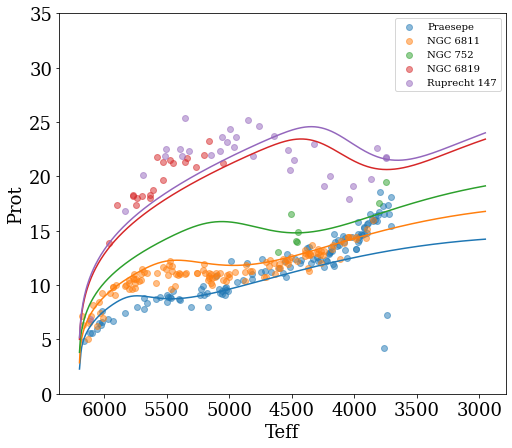

In [297]:
ok = np.where((cl['Age'] > .5) & 
              (cl['Teff'] > 3700) & 
              (cl['Teff'] < 6200))[0]

p0 = (0.55, 0.4, -0.45, 0.31)

X = (teff2bv(cl['Teff'][ok].values), cl['Age'][ok].values*1e3)

popt, pcov = curve_fit(myfunc2, X, cl['Prot'].values[ok], p0=p0, maxfev=10000) 
#                        bounds=([0.1, 0.3, -50, 0.01], [0.9, 1.8, -1, 1]))

print(p0)
print(popt)

# then plot them individually
plt.figure(figsize=(8,7))
for k in cl['Cluster'][ok].unique():
    ok2 = cl['Cluster'][ok] == k
    plt.scatter(cl['Teff'][ok][ok2], cl['Prot'][ok][ok2], alpha=0.5, label=k)
plt.gca().invert_xaxis()
plt.xlabel('Teff')
plt.ylabel('Prot')
plt.legend(fontsize=10)

for k in range(len(cl['Age'][ok].unique())):
    plt.plot(bv2teff(bv_c), myfunc2((bv_c, cl['Age'][ok].unique()[k]*1e3), *popt) )
plt.ylim(0,35)
# plt.title('Ro1='+format(popt[0],'6.4f') + ' Ro2='+format(popt[1],'6.4f')+
#           ' skw='+format(popt[2],'6.3f')+' samp='+format(popt[3],'6.4f'),fontsize=12)

Well, that only does marginally better, fitting the gyrochrone by keeping the stalldown parameters fixed...

I read this as: a constant rossby number and a constant dip amplitude doesn't quite work (at least w/ this tau definition)

I guess one more thing to try is fitting BOTH the gyro and the stalldown together.

and then next step (sigh) would be to modify the gyro? - which actually might make good sense since the angular momentum loss shouldn't be the exact same efficiency before the stall (envelope loss only) and after (after evelope coupling) - but it's fairly unbounded *how* to do this (to me)

In [300]:
def myfunc3(x, c1,c2,c3,c4, Ro1, Ro2, skw, samp):

    BV, age = x

    Teff = bv2teff(BV)
    tau = CranmerSaar2011_eqn36(Teff)
    
    P1 = Ro1 * tau
    P2 = Ro2 * tau

    t1 = np.power(P1 / (c2 * ((BV + c3) ** c4)), 1. / c1)
    t2 = np.power(P2 / (c2 * ((BV + c3) ** c4)), 1. / c1)

    dP = skewnorm(skw, loc=(t1+t2)/2, scale=(t2 - t1)/2).pdf(age) 
    dP = dP  * (t2 - t1)/2 * np.sqrt(2*np.pi) / 2 * np.exp(1/(2*np.abs(skw))) * ((P1-P2)*samp)

    P = dP + (age ** c1) * c2 * ((BV + c3) ** c4)
    return P

<ipython-input-300-72122e88717b>:11: RuntimeWarning: invalid value encountered in power
  t1 = np.power(P1 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-300-72122e88717b>:12: RuntimeWarning: invalid value encountered in power
  t2 = np.power(P2 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-300-72122e88717b>:17: RuntimeWarning: invalid value encountered in power
  P = dP + (age ** c1) * c2 * ((BV + c3) ** c4)


(0.55, 0.4, -0.45, 0.31, 0.48037859, 0.77893968, -1.98533413, 0.457417)
[ 2.47940657e-01  5.25737158e+00 -5.10132592e-01  3.59574381e-01
  5.50816879e-02  1.02765537e+00  9.78923904e-02  4.98184170e-03]


<ipython-input-300-72122e88717b>:11: RuntimeWarning: invalid value encountered in power
  t1 = np.power(P1 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-300-72122e88717b>:12: RuntimeWarning: invalid value encountered in power
  t2 = np.power(P2 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-300-72122e88717b>:17: RuntimeWarning: invalid value encountered in power
  P = dP + (age ** c1) * c2 * ((BV + c3) ** c4)
<ipython-input-300-72122e88717b>:11: RuntimeWarning: invalid value encountered in power
  t1 = np.power(P1 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-300-72122e88717b>:12: RuntimeWarning: invalid value encountered in power
  t2 = np.power(P2 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython-input-300-72122e88717b>:17: RuntimeWarning: invalid value encountered in power
  P = dP + (age ** c1) * c2 * ((BV + c3) ** c4)
<ipython-input-300-72122e88717b>:11: RuntimeWarning: invalid value encountered in power
  t1 = np.power(P1 / (c2 * ((BV + c3) ** c4)), 1. / c1)
<ipython

(0.0, 35.0)

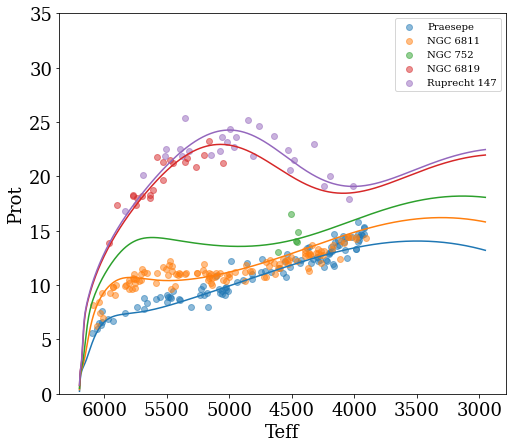

In [305]:
ok = np.where((cl['Age'] > .5) & 
              (cl['Teff'] > 3900) & 
              (cl['Teff'] < 6100))[0]

p0 = (0.55, 0.4, -0.45, 0.31, 0.48037859,  0.77893968, -1.98533413,  0.457417)

X = (teff2bv(cl['Teff'][ok].values), cl['Age'][ok].values*1e3)

popt, pcov = curve_fit(myfunc3, X, cl['Prot'].values[ok], p0=p0, maxfev=10000) 
#                        bounds=([0.1, 0.3, -50, 0.01], [0.9, 1.8, -1, 1]))

print(p0)
print(popt)

# then plot them individually
plt.figure(figsize=(8,7))
for k in cl['Cluster'][ok].unique():
    ok2 = cl['Cluster'][ok] == k
    plt.scatter(cl['Teff'][ok][ok2], cl['Prot'][ok][ok2], alpha=0.5, label=k)
plt.gca().invert_xaxis()
plt.xlabel('Teff')
plt.ylabel('Prot')
plt.legend(fontsize=10)

for k in range(len(cl['Age'][ok].unique())):
    plt.plot(bv2teff(bv_c), myfunc3((bv_c, cl['Age'][ok].unique()[k]*1e3), *popt) )
plt.ylim(0,35)
